<img src='../img/acam_logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='65%'></img>

<br>

# Workflow - Indonesian Fires - 2020

Indonesia experiences each year forest fires, especially during the dry season between March and October, with the more severe fires occuring between July and September. Provinces that are often affected are west, central and south Kalimantan (Borneo island) as well as Riau, Jambi and South Sumatra. Read more about the causes and effects of the fires in this [BBC article](https://www.bbc.com/news/world-asia-34265922) describing the fires in 2020.

This workflow features fire occurences in west, central and south Kalimantan in 2020. The dynamics and extent of the fires were monitored by different sensors and data. This notebook covers the following data products:
<a id="top"></a>
- [MLS/AURA - Carbon Monoxide - Level 3](#mls_aura_2020)
- [Sentinel-3 OLCI - RGB](#sentinel3_olci)
- [Sentinel-5P TROPOMI - Carbon Monoxide (CO) - Level 2](#sentinel_5p_co)
- [Sentinel-5P TROPOMI - Ultraviolet Aerosol Index (UVAI) - Level 2](#sentinel_5p_uvai)



<br>

<img src='../img/Peatland-burning-Indonesia.jpeg' alt='Indonesian Fires 2020, source: https://www.climatechangenews.com/2020/08/18/forest-destruction-spiked-indonesia-coronavirus-lockdown/' align='center' width='60%'></img>

<i>Caption: A man tries to extinguish fire on peatland at a sanctuary reserve area inside an oil palm concession in Central Kalimantan.</i><br> Image from [climatechangenews.com](https://www.climatechangenews.com/2020/08/18/forest-destruction-spiked-indonesia-coronavirus-lockdown/).

<hr>

#### Load required libraries

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
from skimage import exposure

from netCDF4 import Dataset
import pandas as pd

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Helper functions

In [3]:
%run ../functions.ipynb

<hr>

## <a id="mls_aura_2020"></a> MLS Level 3 Carbon monoxide (CO) product

The [Microwave Limb Sounder (MLS)](https://disc.gsfc.nasa.gov/information/data-release?title=New%20MLS%20v4.2%20Level%203%20Gridded%20Data%20Products%20Released ) is an instrument onboard the Earth Observing System (EOS) Aura spacecraft. It measures naturally-occurring microwave thermal emission from the limb (edge) of Earth's atmosphere to remotely sense vertical profiles of atmospheric gases, temperature, pressure, and cloud ice. MLS Level 3 data are geophysical products that are binned onto regular grids. They are disseminated in `netCDF` format. 

### Load and browse MLS CO Level 3 data with `xarray`

Each MLS Monthly Binned Level 3 file is organised in six groups:

- `<product> PressureGrid`: 4°×5° geodetic longitude/latitude grid on pressure surfaces
- `<product> ThetaGrid`: 4°×5° geodetic longitude/latitude grid on potential temperature surfaces
- `<product> PressureZM`: 4° geodetic latitude zonal mean on pressure surfaces
- `<product> ThetaZM`: 4° geodetic latitude zonal mean on potential temperature surfaces
- `<product> EqlZM`: 4° equivalent latitude zonal mean on potential temperature surfaces
- `<product> VortexAvg`: Polar vortex average values for each hemisphere on potential temperature surfaces.

`xarray`'s function `open_dataset` enables you to open a `netCDF` file. Once loaded, you can inspect the data structure of the `MLS Level 3` data disseminated by the GES-DISC. In order to load the variable as part of the MLS Monthly Binned Level 3 file, you have to specify the following keyword arguments, replacing `<product>` with the product name, e.g. `CO`: 
- `group='CO PressureGrid'`: to load the `CO PressureGrid` group

#### <a id='step1'></a>Load the MLS Level 3 data

In [4]:
file_name_co = '../eodata/mls/ML3MBCO/2020/09/MLS-Aura_L3MB-CO_v04-23-c01_2020.nc'
file_co = xr.open_dataset(file_name_co, group='CO PressureGrid')
file_co

<xarray.Dataset>
Dimensions:          (lat: 45, lev: 37, lon: 72, nv: 2, time: 12)
Coordinates:
  * lon              (lon) float32 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
  * lat              (lat) float32 -88.0 -84.0 -80.0 -76.0 ... 80.0 84.0 88.0
  * time             (time) datetime64[ns] 2020-01-15 2020-02-15 ... 2020-12-15
  * lev              (lev) float32 1000.0 681.29205 ... 2.1544347e-05 1e-05
Dimensions without coordinates: nv
Data variables:
    lon_bnds         (lon, nv) float32 ...
    lat_bnds         (lat, nv) float32 ...
    time_bnds        (time, nv) datetime64[ns] ...
    value            (time, lev, lon, lat) float32 ...
    rms_uncertainty  (time, lev, lon, lat) float32 ...
    minimum          (time, lev, lon, lat) float32 ...
    maximum          (time, lev, lon, lat) float32 ...
    std_dev          (time, lev, lon, lat) float32 ...
    nvalues          (time, lev, lon, lat) float64 ...
Attributes:
    VerticalCoordinate:   Pressure
    LatLonGridType:       Geodetic
    LatitudeResolution:   4.0
    LongitudeResolution:  5.0
    DataSubset:           None

MLS `<product> PressureGrid` and `<product> ThetaGrid` product groups have four **dimensions**:
* `lon`: the longitude at center of the grid cell 
* `lat`: the latitude at center of the grid cell
* `time`: the date of the grid cell
* `lev`: the vertical coordinate (i.e. pressure/potential temperature values)

You see that the loaded data object also contains nine **data variables**:
* `lon_bnds`: the longitude at the boundaries of the grid cell
* `lat_bnds`: the latitude at the boundaries of the grid cell
* `time_bnds`: the boundaries of the time period (days since 1950-01-01)
* `value`: the average value for each bin
* `rms_uncertainty`: the root mean square of all the Level 2 L2GPPrecision values that contributed to each bin (note that this has not been divided by √nvalues)
* `minimum`: the minimum value in each bin
* `maximum`: the maximum value in each bin
* `std_dev`: the standard deviation of the data in each bin
* `nvalues`: the number of valid data points found in each bin


If you examine the `time` coordinate, you will notice that the dataset has 12 timesteps for each month in 2020 one entry.

### Retrieve the variable `value` as xarray.DataArray

You can specify one variable of interest by putting the name of the variable into square brackets `[]` and get more detailed information about the variable. E.g. `value` is the 'Average Value of Carbon Monoxide', has the unit `vmr` and has four dimensions, `time`, `lev`, `lon` and `lat` respectively. Note that `vmr` stands for volume mixing ratio.

In [5]:
co = file_co['value']
co

<xarray.DataArray 'value' (time: 12, lev: 37, lon: 72, lat: 45)>
[1438560 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * lat      (lat) float32 -88.0 -84.0 -80.0 -76.0 -72.0 ... 76.0 80.0 84.0 88.0
  * time     (time) datetime64[ns] 2020-01-15 2020-02-15 ... 2020-12-15
  * lev      (lev) float32 1000.0 681.29205 464.15887 ... 2.1544347e-05 1e-05
Attributes:
    long_name:  Average Value of Carbon Monoxide
    units:      vmr
    comments:   The average value in a bin

You can retrieve the array values of the variable with squared brackets: `[:,:,:,:]`, which corresponds to the dimensions in this order: `[time, lev, lon, lat]`. One single time step can be selected by specifying one value of the `time` dimension, e.g. `[8,:,:,:]`. This corresponds to selecting the data for the `September 2020`.

In [6]:
co_day = co[8,:,:,:]
co_day

<xarray.DataArray 'value' (lev: 37, lon: 72, lat: 45)>
[119880 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * lat      (lat) float32 -88.0 -84.0 -80.0 -76.0 -72.0 ... 76.0 80.0 84.0 88.0
    time     datetime64[ns] 2020-09-15
  * lev      (lev) float32 1000.0 681.29205 464.15887 ... 2.1544347e-05 1e-05
Attributes:
    long_name:  Average Value of Carbon Monoxide
    units:      vmr
    comments:   The average value in a bin

Now, we want to retrieve the data at two levels: `100 hPa` and `215 hPa`. 

To do this in a single step, we can use `[8,6,:,:]` for `100 hPa` and `[8,4,:,:]` for `215 hPa`.

In [7]:
co_100hpa = co[8,6,:,:]
co_100hpa

<xarray.DataArray 'value' (lon: 72, lat: 45)>
array([[         nan,          nan, 3.438482e-08, ..., 3.814581e-08,
                 nan,          nan],
       [         nan,          nan, 3.179960e-08, ..., 3.345834e-08,
                 nan,          nan],
       [         nan,          nan, 3.101025e-08, ..., 3.556110e-08,
                 nan,          nan],
       ...,
       [         nan,          nan, 3.006750e-08, ..., 3.755859e-08,
                 nan,          nan],
       [         nan,          nan, 3.179825e-08, ..., 3.635739e-08,
                 nan,          nan],
       [         nan,          nan, 3.305765e-08, ..., 3.956220e-08,
                 nan,          nan]], dtype=float32)
Coordinates:
  * lon      (lon) float32 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * lat      (lat) float32 -88.0 -84.0 -80.0 -76.0 -72.0 ... 76.0 80.0 84.0 88.0
    time     datetime64[ns] 2020-09-15
    lev      float32 100.0
Attributes:
    long_name:  Average Value of Carbon Monoxide
    units:      vmr
    comments:   The average value in a bin

In [8]:
co_215hpa = co[8,4,:,:]
co_215hpa

<xarray.DataArray 'value' (lon: 72, lat: 45)>
array([[         nan,          nan, 4.804392e-08, ..., 4.939515e-08,
                 nan,          nan],
       [         nan,          nan, 4.790673e-08, ..., 5.156409e-08,
                 nan,          nan],
       [         nan,          nan, 4.590835e-08, ..., 5.116067e-08,
                 nan,          nan],
       ...,
       [         nan,          nan, 4.152842e-08, ..., 5.409848e-08,
                 nan,          nan],
       [         nan,          nan, 4.877896e-08, ..., 4.860120e-08,
                 nan,          nan],
       [         nan,          nan, 4.733513e-08, ..., 5.566321e-08,
                 nan,          nan]], dtype=float32)
Coordinates:
  * lon      (lon) float32 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * lat      (lat) float32 -88.0 -84.0 -80.0 -76.0 -72.0 ... 76.0 80.0 84.0 88.0
    time     datetime64[ns] 2020-09-15
    lev      float32 215.44347
Attributes:
    long_name:  Average Value of Carbon Monoxide
    units:      vmr
    comments:   The average value in a bin

##  <a id="visualize"></a>Visualize the MLS CO Level 3 data

#### Visualize the data array with a global extent in a `PlateCarree()` projection with the function `visualize_pcolormesh`

The final step is to visualize the gridded data with the function [visualize_pcolormesh](./functions.ipynb#visualize_pcolormesh).

The following keyword arguments have to be defined:
* `data_array`
* `longitude`
* `latitude`
* `projection`
* `color palette`
* `unit`
* `long_name`
* `vmin`, 
* `vmax`

We need to transpose the dataset using `xarray.DataArray.transpose` in order to plot the data array.

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Average Value of Carbon Monoxide (100 hPa) for 2020-09-15'}>)

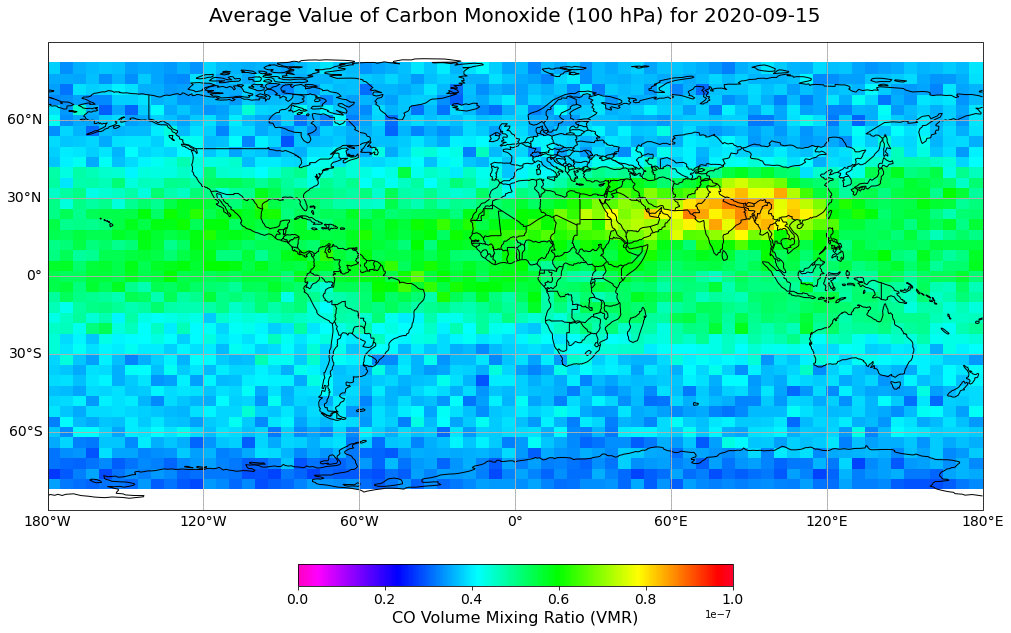

In [12]:
visualize_pcolormesh(data_array=co_100hpa.transpose(), 
                     longitude=co_100hpa.lon, 
                     latitude=co_100hpa.lat, 
                     projection=ccrs.PlateCarree(), 
                     color_scale='gist_rainbow_r', 
                     unit='CO Volume Mixing Ratio (VMR)', 
                     long_name=co_100hpa.long_name + ' (100 hPa) for ' + str(co_100hpa.time.data)[0:10], 
                     vmin=0, 
                     vmax=1e-07)

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Average Value of Carbon Monoxide (215 hPa) for 2020-09-15'}>)

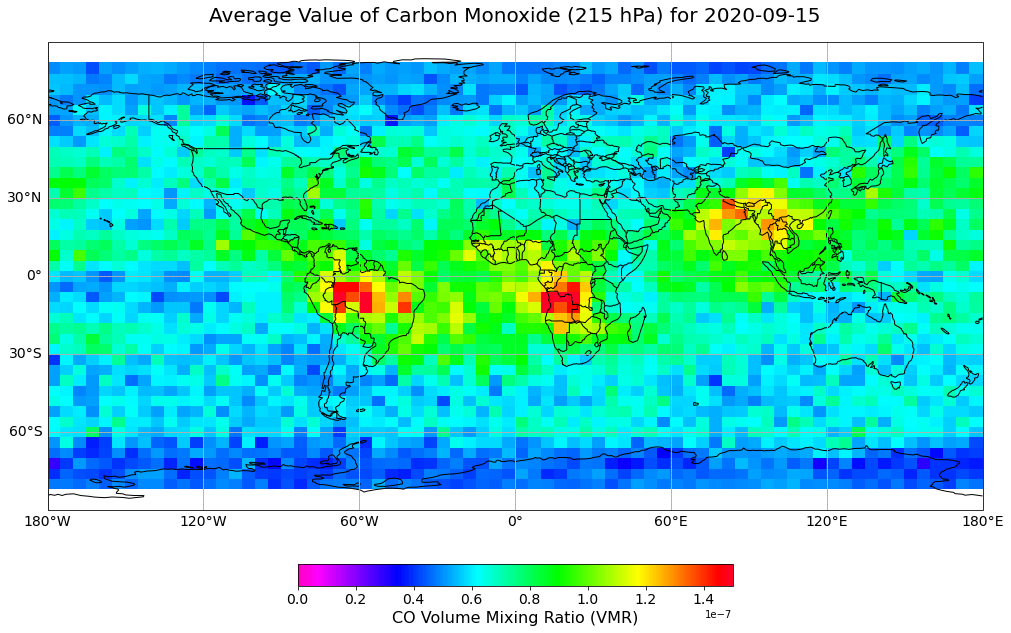

In [13]:
visualize_pcolormesh(data_array=co_215hpa.transpose(), 
                     longitude=co_215hpa.lon, 
                     latitude=co_215hpa.lat, 
                     projection=ccrs.PlateCarree(), 
                     color_scale='gist_rainbow_r', 
                     unit='CO Volume Mixing Ratio (VMR)', 
                     long_name=co_215hpa.long_name + ' (215 hPa) for ' + str(co_215hpa.time.data)[0:10], 
                     vmin=0, 
                     vmax=1.5e-07)

<br>

## <a id='sentinel3_olci'></a>Sentinel-3 OLCI Level 1 RGB

Sentinel-3 OLCI Level 1 RGB composites can highlight areas of smoke resulting from wildfires. Let us go through step by step to load Sentinel-3 OLCI Level 1 data and to build a RGB false color composite.

#### Load OLCI channel information into one xarray object with xarray's function `open_mfdataset`

You can load multiple files at once with the xarray function `open_mfdataset`. In the case of Sentinel-3 OLCI Level-1 data, you want to combine the data of all 21 channels into one xarray object. The structure of the single data files is equal, thus you can combine the data by coordinates by using the keyword argument `by_coords`.

In [10]:
olci_dir = '../eodata/sentinel3/olci/S3B_OL_1_EFR____20200917T021950_20200917T022250_20200918T063231_0179_043_274_3060_MAR_O_NT_002.SEN3/'


In [11]:
olci_xr_mf = xr.open_mfdataset(olci_dir+'*_radiance.nc', combine='by_coords')
olci_xr_mf

<xarray.Dataset>
Dimensions:        (columns: 4865, rows: 4091)
Dimensions without coordinates: columns, rows
Data variables:
    Oa01_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa02_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa03_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa04_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa05_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa06_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa07_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa08_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa09_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa10_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa11_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa12_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa13_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa14_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa15_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa16_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa17_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa18_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa19_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa20_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa21_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
Attributes:
    absolute_orbit_number:  12481
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                ops@eumetsat.int
    creation_time:          2020-09-18T06:32:31Z
    history:                  2020-09-18T06:32:31Z: PUGCoreProcessor /data/ip...
    institution:            MAR
    netCDF_version:         4.2 of Jul  5 2012 17:07:43 $
    product_name:           S3B_OL_1_EFR____20200917T021950_20200917T022250_2...
    references:             S3IPF PDS 004.1 - i2r2 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-1-EO 06.08
    start_time:             2020-09-17T02:19:50.320641Z
    stop_time:              2020-09-17T02:22:50.288392Z
    title:                  OLCI Level 1b Product, Radiance Oa01 Data Set

<br>

#### Load the geo-coordinates and retrieve the data for `latitude` and `longitude`

You might want to georeference the resulting RGB image. Thus, you can already load the `geo_coordinates.nc` file and retrieve `latitude` and `longitude` information.

In [12]:
olci_geo_coords = xr.open_dataset(olci_dir+'geo_coordinates.nc')

lat = olci_geo_coords.latitude.data
lon = olci_geo_coords.longitude.data

<br>

#### Select the channels for the RGB composite

The function [select_channels_for_rgb](./functions.ipynb#rgb_channels) selects the chosen channels from the loaded xarray object. In this case, we select the channels `#17`, `#05` and `#02`. Those channels allow to build a false color composite that highlights healthy vegetation in red and also shows the fire smokes more prominently.

In [6]:
red, green, blue = select_channels_for_rgb(olci_xr_mf, 'Oa17_radiance', 'Oa05_radiance', 'Oa02_radiance')


<br>

#### Normalize the channels `red`, `green` and `blue`

The function [normalize](./functions.ipynb#normalize) normalizes the data values within a range between 0 and 1.

In [7]:
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

<br>

#### Stack the RGB channels into a multi-dimensional array with `np.dstack`

The next step is to combine the three channels `red`, `green` and `blue` into one array stack. You can use the function `np.dstack()` to combined numpy arrays into a stack.

In [8]:
rgb = np.dstack((redn, greenn, bluen))
rgb.shape

(4091, 4865, 3)

<br>

#### Apply a histogram equalization 

A histogram equalization can improve the contrast of the resulting RGB composite. Thus, we use the function `equalize_adapthist` from the exposure module part of the ski-kit-learn library to equalize the image based on the data's histogram.

In [9]:
rgb = exposure.equalize_adapthist(rgb)

<br>

#### Map the rgb values onto a color array

If you want to visualize a georeferenced RGB image, you have to map the rgb values onto a color array with the following code:

In [10]:
mesh_rgb = rgb[:, :-1, :]
colorTuple = mesh_rgb.reshape((mesh_rgb.shape[0] * mesh_rgb.shape[1]), 3)
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

<br>

#### Visualize the final RGB false color composite with the function `visualize_s3_pcolormesh`

Let us visualize the color array in a georeferenced way with the function [visualize_s3_pcolormesh](./functions.ipynb#visualize_s3_pcolormesh).

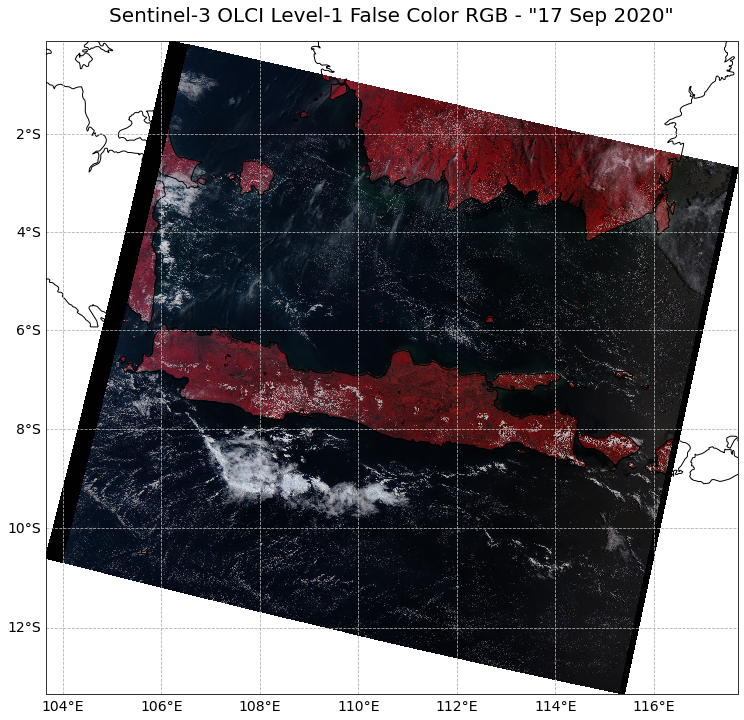

In [11]:
visualize_s3_pcolormesh(color_array=colorTuple, 
                        array=red, 
                        latitude=lat, 
                        longitude=lon, 
                        title='Sentinel-3 OLCI Level-1 False Color RGB - "17 Sep 2020"')

^ [Return to the top](#top)

<br>

## <a id="sentinel_5p_co"></a> Sentinel-5P TROPOMI - Carbon Monoxide (CO) - Level 2

Sentinel-5P carries the `TROPOMI` instrument, which is a spectrometer in the UV-VIS-NIR-SWIR spectral range. `TROPOMI` provides measurements on:
* `Ozone`
* `NO`<sub>`2`</sub>
* `SO`<sub>`2`</sub>
* `Formaldehyde`
* `Aerosol`
* `Carbon monoxide`
* `Methane`
* `Clouds`

This section introduces the Sentinel-5P TROPOMI Carbon monoxide data and how it can be used to monitor wildfires.

### Load and browse a Sentinel-5P TROPOMI Carbon Monoxide data file

The first step is to load a Sentinel-5P TROPOMI Carbon Monoxide data file as `xarray.Dataset` with the `open_dataset()` function from the `xarray` library. You have to specify the keyword argument `group` in order to load the actual data values.

In [44]:
file = xr.open_dataset('../eodata/sentinel5p/S5P_OFFL_L2__CO_____20200917T044812_20200917T062941_15178_01_010302_20200918T183114.nc', group='PRODUCT')
file

<xarray.Dataset>
Dimensions:                                (corner: 4, ground_pixel: 215, layer: 50, scanline: 3736, time: 1)
Coordinates:
  * scanline                               (scanline) float64 0.0 ... 3.735e+03
  * ground_pixel                           (ground_pixel) float64 0.0 ... 214.0
  * time                                   (time) datetime64[ns] 2020-09-17
  * corner                                 (corner) float64 0.0 1.0 2.0 3.0
  * layer                                  (layer) float32 49500.0 ... 500.0
    latitude                               (time, scanline, ground_pixel) float32 ...
    longitude                              (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                             (time, scanline) datetime64[ns] ...
    time_utc                               (time, scanline) object ...
    qa_value                               (time, scanline, ground_pixel) float32 ...
    carbonmonoxide_total_column            (time, scanline, ground_pixel) float32 ...
    carbonmonoxide_total_column_precision  (time, scanline, ground_pixel) float32 ...

<br>

### <a id='data_retrieve_s5p'></a>Retrieve the variable `carbonmonoxide_total_column` as xarray.DataArray

Load the variable of interest `carbonmonoxide_total_column`. You can do so by specifying the name of the variable and put it into square brackets `[]`.

In [45]:
co = file['carbonmonoxide_total_column']
co

<xarray.DataArray 'carbonmonoxide_total_column' (time: 1, scanline: 3736, ground_pixel: 215)>
[803240 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 3.734e+03 3.735e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
  * time          (time) datetime64[ns] 2020-09-17
    latitude      (time, scanline, ground_pixel) float32 ...
    longitude     (time, scanline, ground_pixel) float32 ...
Attributes:
    units:                                                 mol m-2
    standard_name:                                         atmosphere_mole_co...
    long_name:                                             Vertically integra...
    ancillary_variables:                                   carbonmonoxide_tot...
    multiplication_factor_to_convert_to_molecules_percm2:  6.022141e+19

<br>

Repeat the previous step for the dimensions `latitude` and `longitude`.

In [46]:
latitude = co['latitude']
longitude = co['longitude']

<br>

Select the first time step by specifying the first value of the `time` dimension, i.e. `[0,:,:]`.

In [47]:
co_1709 = co[0,:,:]
co_1709

<xarray.DataArray 'carbonmonoxide_total_column' (scanline: 3736, ground_pixel: 215)>
[803240 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 3.734e+03 3.735e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
    time          datetime64[ns] 2020-09-17
    latitude      (scanline, ground_pixel) float32 ...
    longitude     (scanline, ground_pixel) float32 ...
Attributes:
    units:                                                 mol m-2
    standard_name:                                         atmosphere_mole_co...
    long_name:                                             Vertically integra...
    ancillary_variables:                                   carbonmonoxide_tot...
    multiplication_factor_to_convert_to_molecules_percm2:  6.022141e+19

<br>

The attributes of the `xarray.DataArray` hold the entry `multiplication_factor_to_convert_to_molecules_percm2`. Let us save the multiplication factor as variable.

In [48]:
conversion_factor = co_1709.multiplication_factor_to_convert_to_molecules_percm2
conversion_factor

6.022141e+19

<br>

The next step is to apply the conversion factor to the `xarray.DataArray` to convert the Carbon Monoxide values from *mol per m<sup>2</sup>* to *molecules per cm<sup>2</sup>*.

In [49]:
co_1709_converted =  co_1709*conversion_factor
co_1709_converted

<xarray.DataArray 'carbonmonoxide_total_column' (scanline: 3736, ground_pixel: 215)>
array([[          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       ...,
       [          nan, 1.9287776e+18, 1.8984124e+18, ...,           nan,
                  nan,           nan],
       [          nan, 1.8430015e+18,           nan, ...,           nan,
                  nan,           nan],
       [          nan, 1.9612315e+18,           nan, ...,           nan,
                  nan,           nan]], dtype=float32)
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 3.734e+03 3.735e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
    time          datetime64[ns] 2020-09-17
    latitude      (scanline, ground_pixel) float32 ...
    longitude     (scanline, ground_pixel) float32 ...

<br>

### Visualize Sentinel-5P TROPOMI Carbon Monoxide data

First, specify a `bounding box` set to the extent of Borneo.

In [50]:
latmin = -5
latmax = 8.
lonmin = 105.
lonmax = 120.

<br>

The last step is to visualize the Carbon Monoxide data for the specified region. You can use the function [visualize_pcolormesh](./functions.ipynb#visualize_pcolormesh).

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Vertically integrated CO column 2020-09-17T00:00:00.000000000'}>)

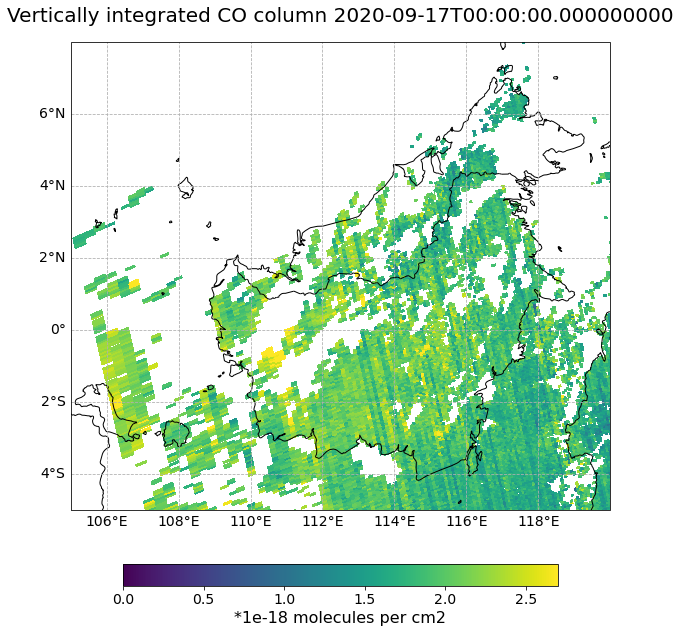

In [51]:
visualize_pcolormesh(data_array=co_1709_converted*1e-18,
                     longitude=co_1709_converted.longitude,
                     latitude=co_1709_converted.latitude,
                     projection=ccrs.PlateCarree(),
                     color_scale='viridis',
                     unit='*1e-18 molecules per cm2',
                     long_name=co_1709.long_name + ' ' + str(co_1709_converted.time.data),
                     vmin=0, 
                     vmax=2.7,
                     lonmin=lonmin,
                     lonmax=lonmax,
                     latmin=latmin,
                     latmax=latmax,
                     set_global=False)

^ [Return to the top](#top)

<br>

## <a id="sentinel_5p_uvai"></a> Sentinel-5P TROPOMI - Ultraviolet Aerosol Index (UVAI) - Level 2

For fire monitoring , the `TROPOMI UV Aerosol Index (UVAI)` data can be used. 

Positive values of UVAI (typically > abt. 1.0) indicate the presence of absorbing-type aerosols: 
- `smoke from forest fires`, 
- `volcanic ash`, or 
- `desert dust`. 



<br>

#### Load a Sentinel-5P TROPOMI UVAI data file

The first step is to load the Sentinel-5P TROPOMI UVAI data file. You can use the function `open_dataset()` from the xarray library to do so. You have to specify the keyword argument `group='PRODUCT'` in order to load the actual data values.

In [20]:
s5P_mf = xr.open_dataset('../eodata/sentinel5p/S5P_OFFL_L2__AER_AI_20200919T055125_20200919T073254_15207_01_010302_20200920T194235.nc', group='PRODUCT')
s5P_mf

<xarray.Dataset>
Dimensions:                          (corner: 4, ground_pixel: 450, scanline: 4173, time: 1)
Coordinates:
  * scanline                         (scanline) float64 0.0 1.0 ... 4.172e+03
  * ground_pixel                     (ground_pixel) float64 0.0 1.0 ... 449.0
  * time                             (time) datetime64[ns] 2020-09-19
  * corner                           (corner) float64 0.0 1.0 2.0 3.0
    latitude                         (time, scanline, ground_pixel) float32 ...
    longitude                        (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                       (time, scanline) datetime64[ns] ...
    time_utc                         (time, scanline) object ...
    qa_value                         (time, scanline, ground_pixel) float32 ...
    aerosol_index_354_388            (time, scanline, ground_pixel) float32 ...
    aerosol_index_340_380            (time, scanline, ground_pixel) float32 ...
    aerosol_index_354_388_precision  (time, scanline, ground_pixel) float32 ...
    aerosol_index_340_380_precision  (time, scanline, ground_pixel) float32 ...

<br>

### Select an `aerosol index` variable

The Sentinel-5p TROPOMI aerosol index data provide the Aerosol Index for two different wavelength pairs: 
- `340_380 nm`
- `354_388 nm` 

Select the data variable `aerosol_index_340_380` together with the geo-coordinates as follows:

In [22]:
uvai = s5P_mf.aerosol_index_340_380[0,:,:]
lat = uvai.latitude
lon = uvai.longitude


<br>

### Read the `Quality Flag` to mask the UVAI data

Another important parameter to read is the general quality flag called `qa_value`. The quality flag removes the sun glint pixels, where "falsely" high positive UVAI values over sea can be detected. In order to exclude sun glint, it is recommended to use only values where the `qa_value` is higher than 0.8. 

In [23]:
qa=s5P_mf.qa_value[0,:,:]

<br>

### Apply the qa value and mask the data

The final step before plotting is to mask the aerosol index data based on the qa mask. You filter data with the `xarray` function `where`.

In [24]:
uvai_masked=uvai.where(qa > 0.8)

<br>

### Visualize the `UV Aerosol Index` value

Specify a `bounding box` set to the extent of the southern part of Borneo.

In [25]:
latmin = -5
latmax = 0.
lonmin = 105.
lonmax = 120.

<br>

The final step is to visualize the gridded data with the function [visualize_pcolormesh](./functions.ipynb#visualize_pcolormesh).

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Aerosol index from 380 and 340 nm'}>)

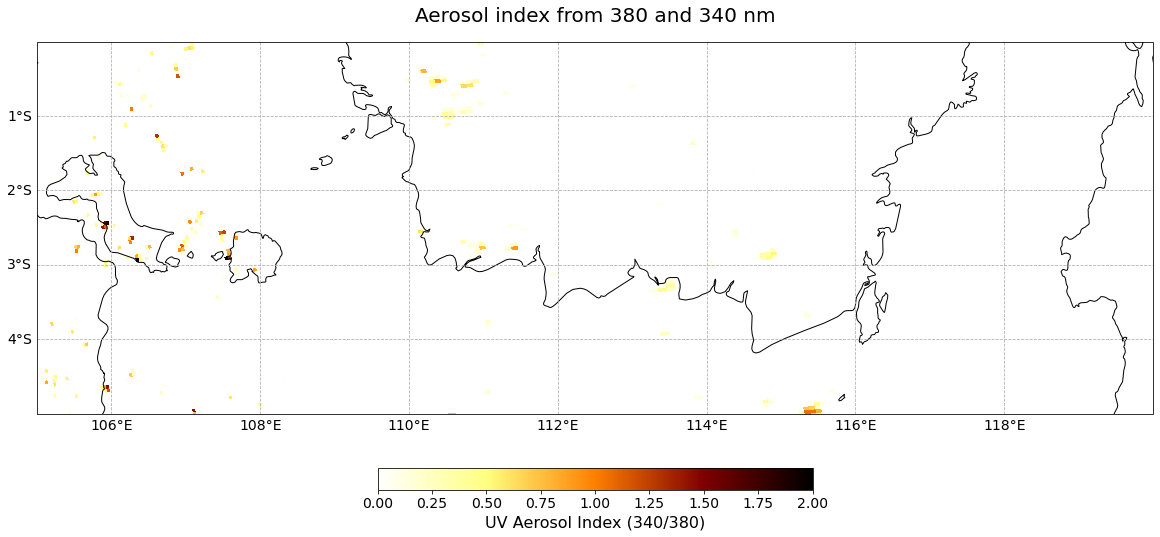

In [26]:
visualize_pcolormesh(data_array=uvai_masked,
                     longitude=lon,
                     latitude=lat,
                     projection=ccrs.PlateCarree(),
                     color_scale='afmhot_r',
                     unit= 'UV Aerosol Index (340/380)',
                     long_name=uvai.long_name,
                     vmin=0, 
                     vmax=2,
                     lonmin=lonmin,
                     lonmax=lonmax,
                     latmin=latmin,
                     latmax=latmax,
                     set_global=False)

<br>

## You have arrived at the end of this workflow highlighting the Indonesian fires during September 2020.

<br>

<img src='../img/indonesia_burnt_area.jpg' alt='Indonesian fires' align='centre' width='60%'></img>

<i>Caption: Burned land is pictured next to a palm oil plantation after fires near Banjarmasin in South Kalimantan province, Indonesia [Source: Willy Kurniawan/Reuters]</a>

^ [Return to the top](#top)

<br>

<hr>

<img src='../img/copernicus_logo.png' alt='Logo EU Copernicus' align='right' width='20%'><br><br><br><br>

<p style="text-align:right;">This project is licensed under the <a href="../LICENSE">MIT License</a> and is developed under a Copernicus contract.